# Image-to-Text Models

## The concept of weatherGPT

It should be an Image-to-Text model with:
- Input: an image (more specificly, a (6,241,121) data array)
- Output: a description of about 250 words
- Model architecture:
    - image -> image encoder -> image-embeddings
    - description -> text encoder -> text-embeddings
    - model: mapping image-embeddings to text-embeddings

### Existing Image-to-Text Models
- [Image-to-Text on HuggingFace](https://huggingface.co/tasks/image-to-text)
    - Image to text models output a text from a given image. Image captioning or optical character recognition can be considered as the most common applications of image to text.
- Image captioning
    - Image Captioning is the process of generating textual description of an image. This can help the visually impaired people to understand what's happening in their surroundings.
- Optical Character Recognition (OCR)
    - OCR models convert the text present in an image, e.g. a scanned document, to text.
- Pix2Struct
    - Pix2Struct is a state-of-the-art model built and released by Google AI. The model itself has to be trained on a downstream task to be used. These tasks include, captioning UI components, images including text, visual questioning infographics, charts, scientific diagrams and more. You can find these models on recommended models of [this page](https://arxiv.org/abs/2210.03347).

### Some Pre-trained I2T models:
- [OpenAI CLIP](https://openai.com/research/clip)
    - [HuggingFace hub](https://huggingface.co/docs/hub/en/open_clip)
    - [GitHub](https://github.com/openai/CLIP)
- [Google Pix2Struct](https://arxiv.org/abs/2210.03347)
    - [HuggingFace Hub](https://huggingface.co/google/pix2struct-large) 
    - [GitHub](https://github.com/google-research/pix2struct)

### Other reference:
- [A Guide to Fine-Tuning CLIP Models with Custom Data](https://medium.com/aimonks/a-guide-to-fine-tuning-clip-models-with-custom-data-6c7c0d1416fb)
- [Let’s Train Image To Text Transformer](https://sushantjha8.medium.com/lets-train-image-to-text-transformer-846150b632ef)
- [GIT: A Generative Image-to-text Transformer for Vision and Language](https://arxiv.org/abs/2205.14100)
- [Implement Convolutional Autoencoder in PyTorch with CUDA](https://www.geeksforgeeks.org/implement-convolutional-aild an encoder.vrxiv.org/abs/2205.14100)

In [1]:
# Data Loader
import numpy as np
import pandas as pd
import os

DATA_PATH = '../../data/ncep_npy/'
# Walk through the sub-directories
file_list = []
for root, dirs, files in os.walk(DATA_PATH):
    for name in files:
        if name.endswith('.npy'):
            date = name.replace('.npy','')
            url = os.path.join(root, name)
            file_list.append({'date':date, 'furi':url})

file_list = pd.DataFrame(file_list)
print(file_list.shape)
print(file_list.head())

(3653, 2)
       date                              furi
0  20110101  ../../data/ncep_npy/20110101.npy
1  20110102  ../../data/ncep_npy/20110102.npy
2  20110103  ../../data/ncep_npy/20110103.npy
3  20110104  ../../data/ncep_npy/20110104.npy
4  20110105  ../../data/ncep_npy/20110105.npy


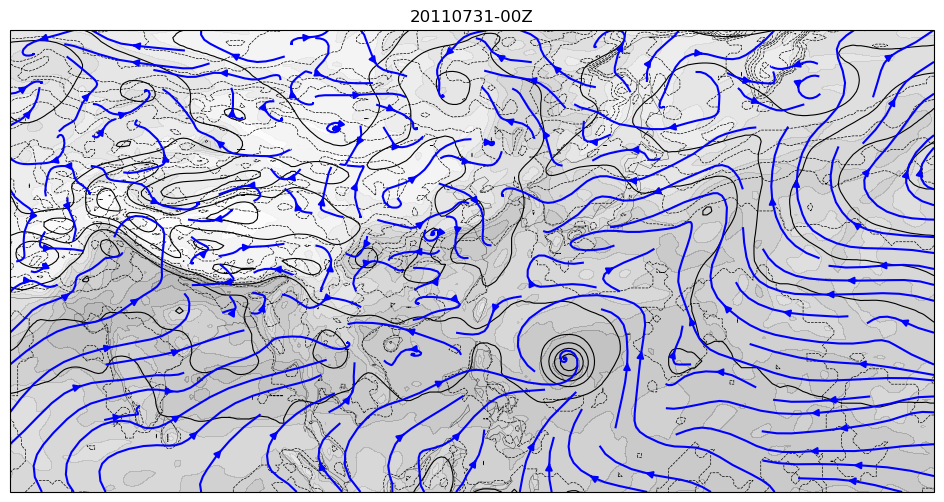

0

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

data = np.load('../../data/ncep_npy/20110731.npy')

def plot_surface_data(data, title=None):
    ''' Visualize the 6x241x121 dataset.  '''
    # Retrieve each variable
    pwat = data[0,:,:]
    slp = data[1,:,:]
    rh = data[2,:,:]
    t = data[3,:,:]
    u = data[4,:,:]
    v = data[5,:,:]
    # Create coordinate
    x = np.linspace(60, 180, 241)
    y = np.linspace(0, 60, 121)
    x2d, y2d = np.meshgrid(x, y)
    # Create map
    crs = ccrs.PlateCarree()
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidths=0.3, alpha=0.8)
    # draw variables
    water = ax.contourf(x2d, y2d, pwat*110, transform=crs, levels=11, cmap='binary', alpha=0.3, label='RH [%]')
    l1 = ax.contour(x2d, y2d, slp*14000+93000, transform=crs, levels=11, colors='black', linestyles='solid', linewidths=0.8, label='P [pa]')
    l2 = ax.contour(x2d, y2d, t*100+220, transform=crs, levels=11, colors='black', linestyles='dashed', linewidths=0.5, label='T [K]')
    wind = ax.streamplot(x2d, y2d, u*120-60, v*120-60, transform=crs, color='blue')
    # draw addons
    ax.set_extent([60, 180, 0, 60], crs=crs)
    if not title is None:
        ax.set_title(title)
    plt.show()
    #
    return(0)

plot_surface_data(data, title='20110731-00Z')

In [3]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
import os
import numpy as np
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader

class MySurfaceDataset(Dataset):
    def __init__(self, data_info, npy_dir, transform=None, target_transform=None):
        self.data_info = data_info
        self.npy_dir = npy_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data_info.shape[0]

    def __getitem__(self, idx):
        data_path = self.data_info['furi'].iloc[idx]
        np_array = np.load(data_path)
        data = torch.from_numpy(np_array)
        label = self.data_info['date'].iloc[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

ncep_data = MySurfaceDataset(data_info=file_list, npy_dir='../../data/ncep_npy/')

## Fine-Tuning an Image-to-Text Model

We want to fine-tune a pre-trained Image-to-Text model for our task. References are:

- [Fine-Tuning Image-to-Text algorithms with LORA](https://www.linkedin.com/pulse/fine-tuning-image-to-text-algorithms-withlora-daniel-puente-viejo/)
- [nlpconnect/vit-gpt2-image-captioning](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning)

We first try the pre-trained model.


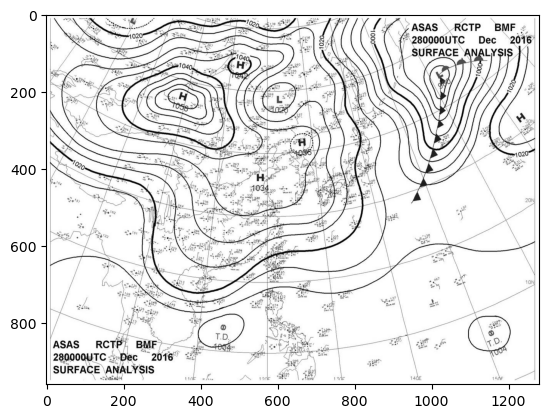

Image shape: (960, 1280, 3)
Feature shapetorch.Size([1, 3, 224, 224])


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


a collage of photos of a person holding a camera 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2TokenizerFast

from datasets import load_dataset
from peft import LoraConfig, get_peft_model
import numpy as np
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loc = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(loc)
feature_extractor = ViTImageProcessor.from_pretrained(loc)
tokenizer = GPT2TokenizerFast.from_pretrained(loc)

model = model.to(device)

def show_n_generate(url, feature_extractor, model, tokenizer):
    image = Image.open(url)
    if image.mode != "RGB":
        image = image.convert(mode="RGB")
    pixel_values = feature_extractor(image, return_tensors ="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # Show image
    plt.imshow(np.asarray(image))
    plt.show()
    # Data dimension
    print('Image shape: ' + str(np.asarray(image).shape))
    print('Feature shape' + str(pixel_values.shape))
    # Generate caption
    gen_kwargs = {"max_length": 256, "num_beams": 4}
    generated_ids  = model.generate(pixel_values, **gen_kwargs)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_text)

show_n_generate('../../data/weather_map/preproc/20161228-1.jpg', feature_extractor, model, tokenizer)

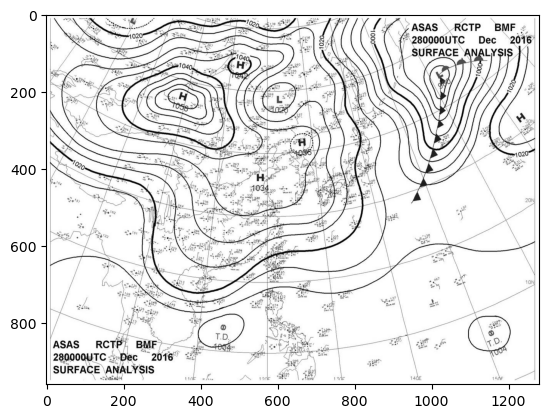

Image shape: (960, 1280, 3)
Feature shapetorch.Size([1, 3, 224, 224])
a collage of photos of a person holding a camera 


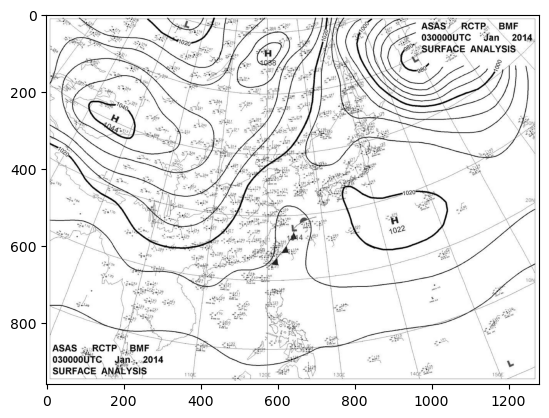

Image shape: (960, 1280, 3)
Feature shapetorch.Size([1, 3, 224, 224])
a collage of photos of a painting of a person 


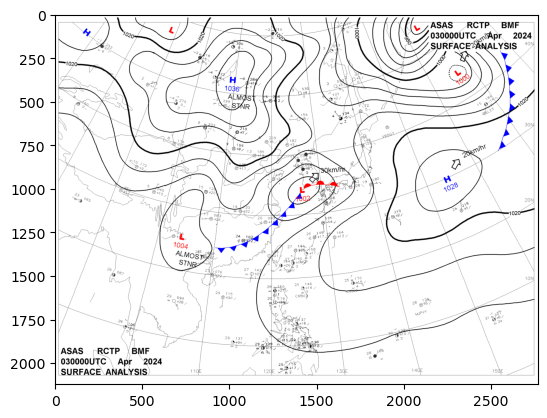

Image shape: (2122, 2770, 3)
Feature shapetorch.Size([1, 3, 224, 224])
a collage of photos of a person on a computer 


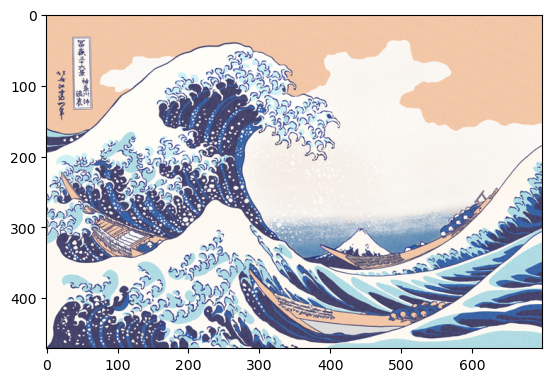

Image shape: (471, 700, 3)
Feature shapetorch.Size([1, 3, 224, 224])
a painting of a penguin on top of a blue wall 


C:\usr\anaconda3\envs\weathergpt\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


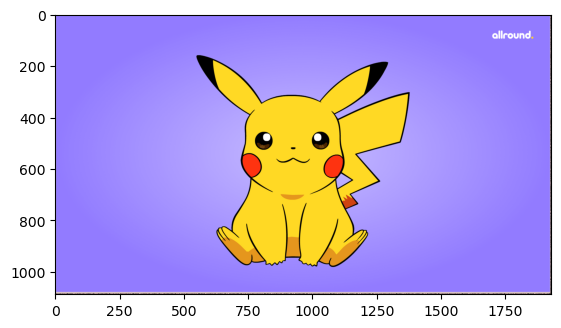

Image shape: (1088, 1929, 3)
Feature shapetorch.Size([1, 3, 224, 224])
a teddy bear with a cartoon character on it 


In [2]:
show_n_generate('../../data/weather_map/preproc/20161228-1.jpg', feature_extractor, model, tokenizer)
show_n_generate('../../data/weather_map/preproc/20140103-1.jpg', feature_extractor, model, tokenizer)
show_n_generate('../data/test/20240403.png', feature_extractor, model, tokenizer)
show_n_generate('../data/test/Tsunami_by_hokusai_19th_century.png', feature_extractor, model, tokenizer)
show_n_generate('../data/test/pikachu.png', feature_extractor, model, tokenizer)

Well, it's obvious that the pre-trained model doesn't know what a "weather map" is. Hence, we need to "teach" it.

There are a few references about fine-tuning and training the **`nlpconnect/vit-gpt2-image-captioning`** model:

- [Using 🤗’s pretrained models for image captioning](https://michael-franke.github.io/npNLG/08-grounded-LMs/08c-NIC-pretrained.html)
- [The Illustrated Image Captioning using transformers](https://ankur3107.github.io/blogs/the-illustrated-image-captioning-using-transformers/)
- [replace pytorch trainer with keras training](https://github.com/huggingface/transformers/blob/main/examples/tensorflow/summarization/run_summarization.py)

### Customized Dataset

We will pair the text and the image data.

In [2]:
import os
import json
import pandas as pd

CWB_TEXT = '../../data/cwb_briefing_all.json'
IMG_PREFIX = '../../data/weather_map/preproc/'

with open(CWB_TEXT, 'r', encoding='utf-8') as f:
    briefing = json.load(f)

df = pd.DataFrame(briefing)

img_url = [IMG_PREFIX+datestr.replace('-','')+'-1.jpg' for datestr in df['date']]
df['img_url'] = img_url
img_not_missing = [os.path.exists(f) for f in df['img_url']]
#print(missing_img)

print(df.shape)
df=df.loc[img_not_missing,:]
print(df.shape)
print(df.head())

(3061, 3)
(3048, 3)
         date                                            content  \
0  2012-02-29  一、高氣壓１０２６百帕，在北緯３８度，東經１２７度，即在韓國，向東緩慢移動。\n二、今（２９...   
1  2012-03-01  一、高氣壓１０１８百帕，在北緯２６度，東經１３３度，即在日本南方海面，向東緩慢移動。\n二、...   
2  2012-03-02  一、低氣壓１０１０百帕，在北緯３３度，東經１３４度，即在日本南方海面，向東北東移動，時速１５...   
3  2012-03-03  一、低氣壓１００８百帕，在北緯３５度，東經１４９度，即在日本東方海面，向東移動，時速１５公里...   
4  2012-03-04  一、高氣壓１０３６百帕，在北緯４３度，東經１３４度，即在日本海，向東南東移動，時速１５公里。...   

                                         img_url  
0  ../../data/weather_map/preproc/20120229-1.jpg  
1  ../../data/weather_map/preproc/20120301-1.jpg  
2  ../../data/weather_map/preproc/20120302-1.jpg  
3  ../../data/weather_map/preproc/20120303-1.jpg  
4  ../../data/weather_map/preproc/20120304-1.jpg  


In [3]:
#df.to_csv('../data/data_info_1.csv', encoding='utf-8', index=False)

In [4]:
# Reference:
# https://michael-franke.github.io/npNLG/08-grounded-LMs/08c-NIC-pretrained.html
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader

import os
import pickle
import pandas as pd
import numpy as np
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2TokenizerFast
loc = "nlpconnect/vit-gpt2-image-captioning"

#model = VisionEncoderDecoderModel.from_pretrained(loc)
feature_extractor = ViTImageProcessor.from_pretrained(loc)
tokenizer = GPT2TokenizerFast.from_pretrained(loc)

class CWBWeatherMap(Dataset):
    """
    Dataset class for loading the dataset of weather-map and briefings.

    Arguments:
    ---------
    num_labels: int
        Number of distinct captions to sample for each image. Relevant for using the dataloader for training models.
    labels_type: str
        "long" or "short". Indicates whether long or short captions should be used.
    run_inference: bool
        Flag indicating whether this dataset will be used for performing inference with a trained image captioner.
    batch_size: int
        Batch size. Has to be 1 in order to save the example image-caption pairs.
    vocab_file: str
        Name of vocab file.
    start_token: str
        Start token.
    end_token: str
        End token.
    unk_token: str
        Token to be used when encoding unknown tokens.
    pad_token: str
        Pad token to be used for padding captions tp max_sequence_length.
    max_sequence_length: int
        Length to which all captions are padded / truncated.
    """
    def __init__(
            self,
            model_name="nlpconnect/vit-gpt2-image-captioning",
            path="../data/",
            data_info_file='data_info_1.csv',
            num_labels=1, # number of ground truth labels to retrieve per image
            labels_type="long", # alternative: short
            run_inference=False, # depending on this flag, check presence of model weights
            batch_size=1,
            vocab_file="vocab.pkl",
            start_token="[SEP]",  # might be unnecessary since vocab file is fixed anyways
            end_token="[SEP]",
            unk_token="[UNK]",
            pad_token="[PAD]",
            max_sequence_length=256, # important for padding length
        ):

        # check vocab file exists
        assert os.path.exists(os.path.join(path, vocab_file)), "Make sure the vocab file exists in the directory passed to the dataloader (see README)"

        # check if data_info file exists
        assert os.path.exists(os.path.join(path, data_info_file)), "Make sure the data_info exists in the directory passed to the dataloader (see README)"

        assert num_labels <= 20, "Maximally 20 distinct image-long caption pairs can be created for one image"

        self.batch_size = batch_size
        # Load vocal_file
        with open(os.path.join(path, vocab_file), "rb") as vf:
            self.vocab = pickle.load(vf)

        self.max_sequence_length = max_sequence_length
        self.start_token = start_token
        self.end_token = end_token
        self.unk_token = unk_token
        self.pad_token = pad_token
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
        #self.feature_extractor = ViTImageProcessor.from_pretrained(model_name)
        
        #
        self.datainfo = pd.read_csv(os.path.join(path, data_info_file), encoding='utf-8')
        self.image_files = self.datainfo['img_url'].to_list()
        self.image_date = self.datainfo['date'].to_list()
        self.image_description = self.datainfo['content'].to_list()


    def __len__(self):
        """
        Returns length of dataset.
        """
        return self.datainfo.shape[0]

    def __getitem__(self, idx):
        """
        Iterator over the dataset.

        Arguments:
        ---------
        idx: int
            Index for accessing the flat image-caption pairs.

        Returns:
        -------
        target_img: np.ndarray (960, 1280, 3)
            Original image.
        target_features: torch.Tensor(2048,)
            ResNet features of the image.
        target_lbl: str
            String caption.
        numeric_lbl: np.ndarray (6,)
            Original numeric image annotation.
        target_caption: torch.Tensor(batch_size, 25)
            Encoded caption.
        """
        # access raw image corresponding to the index in the entire dataset
        target_img = Image.open(self.image_files[idx])
        if target_img.mode != "RGB":
            target_img = target_img.convert(mode="RGB")
        # access caption
        target_lbl = str(self.image_description[idx])
        if len(target_lbl)>256:
            target_lbl = target_lbl[:256]
        # access original numeric annotation of the image
        #numeric_lbl = self.numeric_labels[self.img_ids_flat[idx]]
        # cast type
        target_img = np.asarray(target_img).astype('uint8')
        # retrieve ResNet features, accessed through original image ID
        #target_features = feature_extractor(target_img, return_tensors ="pt").pixel_values
        # tokenize label
        #tokens = self.tokenizer(str(target_lbl).lower().replace("-", " "))
        # Convert caption to tensor of word ids, append start and end tokens.
        #target_caption = self.tokenize_caption(tokens)
        # convert to tensor
        #target_caption = torch.Tensor(target_caption).long()
        #
        #return target_img, target_features, target_lbl, target_caption
        return target_img, target_lbl

    
    def tokenize_caption(self, label):
        """
        Helper for converting list of tokens into list of token IDs.
        Expects tokenized caption as input.

        Arguments:
        --------
        label: list
            Tokenized caption.

        Returns:
        -------
        tokens: list
            List of token IDs, prepended with start, end, padded to max length.
        """
        label = label[:(self.max_sequence_length-2)]
        tokens = [self.vocab["word2idx"][self.start_token]]
        for t in label:
            try:
                tokens.append(self.vocab["word2idx"][t])
            except:
                tokens.append(self.vocab["word2idx"][self.unk_token])
        tokens.append(self.vocab["word2idx"][self.end_token])
        # pad
        while len(tokens) < self.max_sequence_length:
            tokens.append(self.vocab["word2idx"][self.pad_token])
        #
        return tokens

    
    def get_labels_for_image(self, id, caption_type="long"):
        """
        Helper for getting all annotations for a given image id.

        Arguments:
        ---------
        id: int
            Index of image caption pair containing the image
            for which the full list of captions should be returned.
        caption_type: str
            "long" or "short". Indicates type of captions to provide.

        Returns:
        -------
            List of all captions for given image.
        """
        return self.image_description[id]


cwb_dataset = CWBWeatherMap()
vocab = cwb_dataset.vocab["word2idx"].keys()
vocab_size = len(vocab)

print(len(cwb_dataset))
print(vocab_size)

3048
21128


### Creating a ’DataLoader’

Let’s create a ’DataLoader’ for batches of a specified size, using a random shuffle of the data. (The current code requires a batch size of 1, unfortunately.)

In [5]:
batch_size = 1
cwb_data_loader = torch.utils.data.DataLoader(
    dataset    = cwb_dataset,
    batch_size = batch_size,
    shuffle    = True,
)

### Fine-tuning training

For fine-tuning, we just iterate once through the whole31k subset of theweather mapS.
 (This might take some 15-20 minutes, depending on your machine.)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2TokenizerFast
from peft import LoraConfig, get_peft_model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loc = "nlpconnect/vit-gpt2-image-captioning"

#model = VisionEncoderDecoderModel.from_pretrained(loc)
model_trained = VisionEncoderDecoderModel.from_pretrained(loc)
feature_extractor = ViTImageProcessor.from_pretrained(loc)
tokenizer = GPT2TokenizerFast.from_pretrained(loc)

optimizer = torch.optim.Adam(model_trained.parameters(), lr=1e-4)


model_trained = model_trained.to(device)

for i in tqdm(range(len(cwb_data_loader.dataset))):
    # get the next training instance
    x = next(iter(cwb_data_loader))

    # retrieve and preprocess image
    image = x[0][0]
    #image = Image.fromarray(image.detach().numpy()) # TODO: necessary?
    pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    # retrieve and preprocess labels
    labels = x[1][0]
    #print(labels)
    labels = tokenizer(labels, return_tensors="pt").input_ids
    #print(labels)
    labels = labels.to(device)

    # compute loss
    loss = model_trained(pixel_values=pixel_values, labels=labels).loss
    #loss = loss.to(device)

    # parameter update
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████████████████████████████████████████████████████████████████████████| 3048/3048 [03:34<00:00, 14.22it/s]


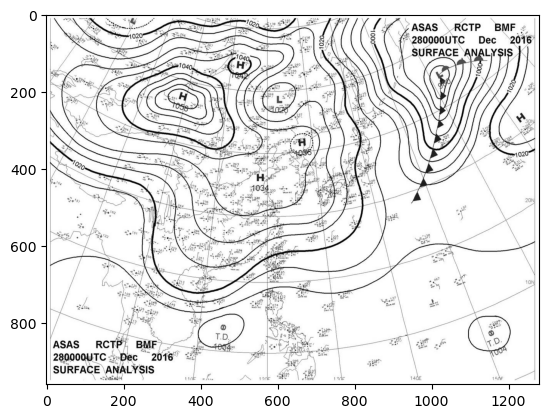

Image shape: (960, 1280, 3)
Feature shapetorch.Size([1, 3, 224, 224])
['天氣特報：請參照本局發布之最新豪(大)雨特報、陸上強風特報。\n高氣壓１０２６百帕，在北緯３３度，東經１３３度，即在蒙古北方，向東南東移動，時速２０公里。\n今（２７）日東北季風影響，北部及東北部天氣較涼，其他地區早晚天氣亦�']


In [11]:
show_n_generate('../../data/weather_map/preproc/20161228-1.jpg', feature_extractor, model_trained, tokenizer)

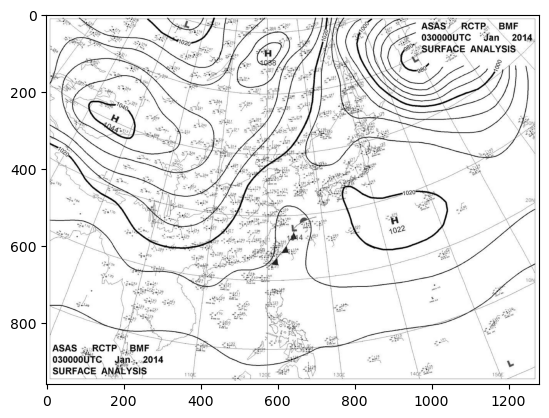

Image shape: (960, 1280, 3)
Feature shapetorch.Size([1, 3, 224, 224])
['一、天氣特報：請參照本局發佈之最新豪(大)雨特報。\n二、高氣壓１０２６百帕，在北緯３３度，東經１３３度，即在日本東方海面，向東北東移動，時速２０公里。\n三、今（２６）日至明（２７日）清晨東北季風影響，北部及東北部天氣較涼�']


In [12]:
show_n_generate('../../data/weather_map/preproc/20140103-1.jpg', feature_extractor, model_trained, tokenizer)

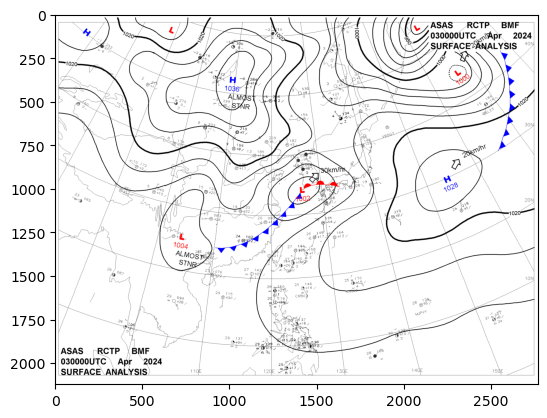

Image shape: (2122, 2770, 3)
Feature shapetorch.Size([1, 3, 224, 224])
['天氣特報：請參照本局發布之最新豪(大)雨特報、陸上強風特報。\n高氣壓１０３６百帕，在北緯３０度，東經１１１度，即在菲律賓東方海面，中心近似滯留。\n今、明（１日、２日）兩天東北季風影響，北部及東北部天氣較涼，其他地區早晚亦涼�']


In [29]:
show_n_generate('../data/test/20240403.png', feature_extractor, model_trained, tokenizer)

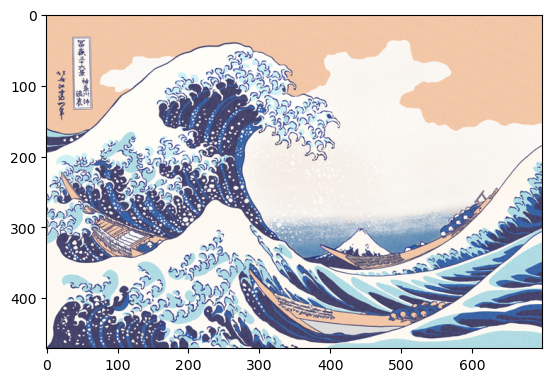

Image shape: (471, 700, 3)
Feature shapetorch.Size([1, 3, 224, 224])
['天氣特報：請參照本局發布之最新豪(大)雨特報、陸上強風特報。\n高氣壓１０２６百帕，在北緯３３度，東經１３３度，即在蒙古東北方，向東北東移動，時速２０公里。\n今（２０）日東北季風影響，北部及東北部天氣較涼，其他地區早晚天氣�']


In [14]:
show_n_generate('../data/test/Tsunami_by_hokusai_19th_century.png', feature_extractor, model_trained, tokenizer)

C:\usr\anaconda3\envs\weathergpt\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


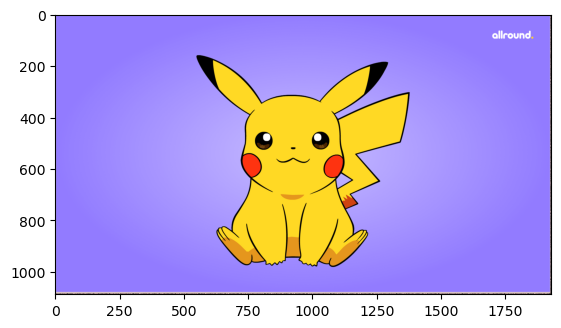

Image shape: (1088, 1929, 3)
Feature shapetorch.Size([1, 3, 224, 224])
['天氣特報：請參照本局發布之最新豪(大)雨特報、陸上強風特報。\n高氣壓１０２６百帕，在北緯３３度，東經１３３度，即在蒙古東北方，向東北東移動，時速２０公里。\n今（２０）日東北季風影響，北部及東北部天氣較涼，其他地區早晚天氣�']


In [16]:
show_n_generate('../data/test/pikachu.png', feature_extractor, model_trained, tokenizer)

In [17]:
torch.save(model_trained.state_dict(), '../data/weathergpt_model')

From the tests above, we found:

- Different weather maps always return the same captions.
- Different types of images return different captions.

It seemed that the image encoder didn't well encode the differences between weather maps. Hence, we must train an encoder specifically for the weather map (or weather model output).